In [ ]:
from src.result_parser import *
from src.utils import load_tokenizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

/home/ubuntu/main-disk/projects/confusability/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
results_dir = "results"
tokens_per_step = 128000

models = [
    {
        "label": "Qwen/Qwen2.5-7B",
        "instruct": False,
    },
    {
        "label": "Qwen/Qwen2.5-7B-Instruct",
        "instruct": True,
    },
    {
        "label": "Qwen/Qwen2.5-3B",
        "instruct": False,
    },
    {
        "label": "Qwen/Qwen2.5-3B-Instruct",
        "instruct": True,
    },
    {
        "label": "meta-llama/Llama-3.2-3B",
        "instruct": False,
    },
    {
        "label": "meta-llama/Llama-3.2-3B-Instruct",
        "instruct": True,
    },
    {
        "label": "meta-llama/Llama-3.1-8B",
        "instruct": False,
    },
    {
        "label": "meta-llama/Llama-3.1-8B-Instruct",
        "instruct": True,
    },
    {
        "label": "openai/gpt-oss-20B",
        "instruct": True,
    },
    {
        "label": "mistralai/Mistral-7B-v0.3",
        "instruct": False,
    },
    {
        "label": "mistralai/Mistral-7B-Instruct-v0.3",
        "instruct": True,
    },
    
]

In [46]:
rows = []
for model in models:
    label = model['label']
    filename = label.split('/')[-1] + ".jsonl"
    path = os.path.join(results_dir, filename)
    tokenizer = load_tokenizer(label)
    vocab_size = tokenizer.vocab_size
    
    # load all events from the log file
    events = load_events(path)
    eval_points = extract_eval_points(events, tokens_per_step)
    assert eval_points, "No eval rows found in the log file"
    
    # Baseline clean eval loss L0: first eval point
    L0 = float(eval_points[0][1])
    logV = math.log(vocab_size) # this is the expected target loss (once the model learns a uniform distribution)
    
    # number of tokens seen to reach z=0.5
    # (i.e. half the way to the target loss, or to lose half the LM capability)
    t_half = interpolate_tokens_for_z_target(eval_points, L0, logV, 0.5)
    
    # initial slope
    initial_slope = interpolate_tokens_for_z_target(eval_points, L0, logV, 0.3)
    
    # tokens seen to lose loss by 0.5 nats
    t_loss_05 = [(t,l) for t, l in eval_points if l - L0 >= 0.5]
    t_loss_05 = t_loss_05[0][0] if t_loss_05 else None
    
    # auc until z=0.5
    # auc_05 = auc_tokens_until_z(eval_points, L0, logV, 0.5)
    
    rows.append({
        "label": label,
        "instruct": model['instruct'],
        "vocab_size": vocab_size,
        "L0": L0,
        "logV": logV,
        "tokens_at_z0.5": t_half,
        "tokens_to_lose_0.5_nats": t_loss_05,
        # "auc_05": auc_05,
        "initial_slope": initial_slope,
        "n_eval_points": len(eval_points),
        "eval_points": eval_points
    })

# Write CSV
df = pd.DataFrame(rows)
df['short_label'] = df['label'].str.split('/').str[1]
df = df.set_index('short_label')

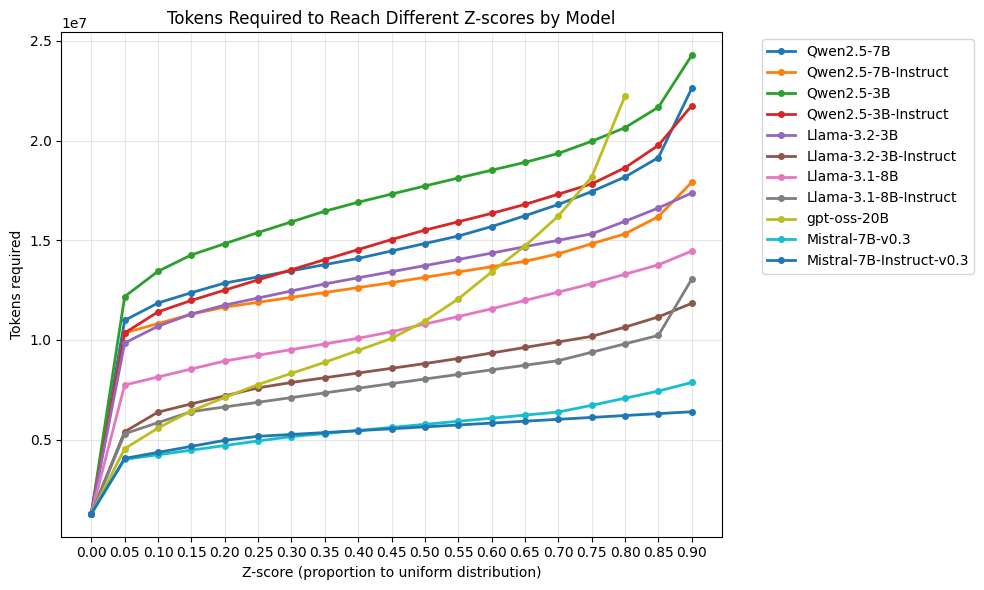

In [47]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
x_values = np.arange(0.0, 0.91, 0.05)

# Plot a line for each model
for idx, row in df.iterrows():
    eval_points = list(row['eval_points'])
    L0 = float(row['L0'])
    logV = float(row['logV'])
    t_across = [interpolate_tokens_for_z_target(eval_points, L0, logV, float(z)) for z in x_values]
    plt.plot(x_values, t_across, marker='o', label=idx, linewidth=2, markersize=4) # type: ignore

plt.xlabel('Z-score (proportion to uniform distribution)')
plt.ylabel('Tokens required')
plt.title('Tokens Required to Reach Different Z-scores by Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(x_values)  # Show all x-tick values
plt.tight_layout()
plt.show()

<Axes: xlabel='short_label'>

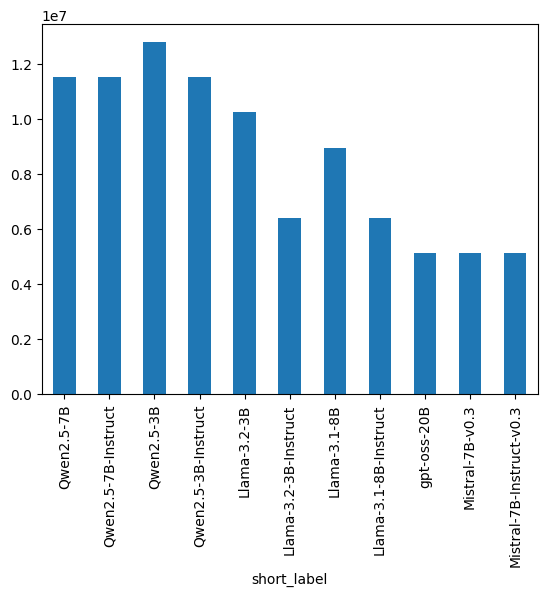

In [48]:
df['tokens_to_lose_0.5_nats'].plot(kind='bar')

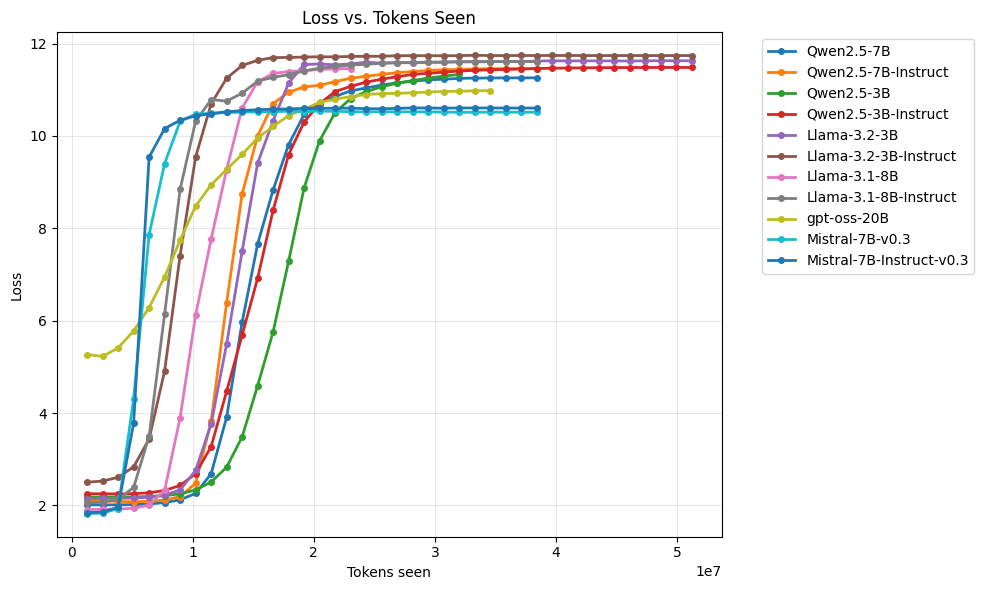

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Plot a line for each model
for idx, row in df.iterrows():
    eval_points = list(row['eval_points'])
    xs = [t for t, _ in eval_points]
    ys = [l for _, l in eval_points]
    plt.plot(xs, ys, marker='o', label=idx, linewidth=2, markersize=4) # type: ignore

plt.xlabel('Tokens seen')
plt.ylabel('Loss')
plt.title('Loss vs. Tokens Seen')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()